In [1]:
from langchain.document_loaders import DirectoryLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_community.document_loaders.base import BaseLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.helpers import detect_file_encodings
from langchain.retrievers import TFIDFRetriever, BM25Retriever, EnsembleRetriever
from datasets import Dataset
import ragas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import pickle
import re
from typing import List, Tuple
import json
import textwrap
import logging


logger = logging.getLogger(__name__)

In [2]:
document_directory = "./../documents"
persist_directory = "./../embeddings"

## Helpers

In [3]:
import sys
import os

current = os.path.dirname(os.path.realpath("."))
parent = os.path.dirname(current)
sys.path.append(parent)

from capstone import secrets

# Only using Open AI because I don't have a GPU and I can't run models locally
os.environ["OPENAI_API_KEY"] = secrets.OPENAI_API_KEY

In [4]:
# Only evaluating context
metrics = [
    # ragas.metrics.answer_relevancy,  # Scores the relevancy of the answer according to the given question.
    # ragas.metrics.answer_similarity,  # Scores the semantic similarity of ground truth with generated answer.
    # ragas.metrics.answer_correctness,  # Measures answer correctness compared to ground truth as a combination of factuality and semantic similarity.
    ragas.metrics.context_precision,  # Average Precision is a metric that evaluates whether all of the relevant items selected by the model are ranked higher or not.
    ragas.metrics.context_recall,  # Estimates context recall by estimating TP and FN using annotated answer and retrieved context.
    ragas.metrics.context_entity_recall,  # Calculates recall based on entities present in ground truth and context.
]

In [5]:
def print_docs(docs: List[Document]) -> None:
    for doc in docs:
        print(textwrap.fill(doc.page_content, 100))
        print("")
        print(json.dumps(doc.metadata, indent=4))
        print("")
        print("=" * 50)
        print("")

In [6]:
def print_docs_with_score(docs: List[Tuple[Document, float]]) -> None:
    for doc, score in docs:
        print(textwrap.fill(doc.page_content, 100))
        print("")
        print(json.dumps(doc.metadata, indent=4))
        print("")
        print("Similarity Score:", score)
        print("")
        print("=" * 50)
        print("")

In [7]:
class ContextFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_contexts(self, question, contexts, ground_truth):
        self.responses["question"].append(question)
        self.responses["contexts"].append([doc.page_content for doc in contexts])
        self.responses["answer"].append("")
        self.responses["ground_truth"].append(ground_truth)

    def get_retrieval_contexts(self):
        return self.responses

## BM25



In [8]:
retrieval_strategy = "bm25"

In [9]:
formatter = ContextFormatter()

In [10]:
# Load documents from persistent store
with open(f"{persist_directory}/documents.pickle", "rb") as handle:
    documents = pickle.load(handle)

retriever = BM25Retriever.from_documents(documents)

In [11]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    contexts = retriever.get_relevant_documents(row["question"])

    formatter.add_contexts(row["question"], contexts, row["ideal_context"])


retrieval_contexts = formatter.get_retrieval_contexts()

with open(f"./cache/{retrieval_strategy}_context.pickle", "wb") as handle:
    pickle.dump(retrieval_contexts, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
with open(f"./cache/{retrieval_strategy}_context.pickle", "rb") as handle:
    retrieval_contexts = pickle.load(handle)

In [13]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

test_data = Dataset.from_dict(retrieval_contexts)

results = ragas.evaluate(test_data, metrics, raise_exceptions=False)

results_df = results.to_pandas()

Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

In [14]:
for i in range(len(results_df["question"])):
    print(results_df["question"][i])
    print(">>>", results_df["ground_truth"][i])
    print("-" * 100)
    print(results_df["contexts"][i][0])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> This course extends Data Mining I and introduces additional data representations and tasks involved in mining real world data, with a particular focus on sequence modeling, time series analysis, and mining data streams.\xa0 It introduces how to extract patterns, compute similarities/distances of data, and make predictions under these data representations.
----------------------------------------------------------------------------------------------------
Data Mining II (SIADS 632), Learning Outcomes: - Be able to formulate real world data as sequences, time series, or data streams.
- Be able to formulate a real world problem as sequence prediction and solve it using N-Gram language models.
- Be aware of how Hidden Markov Models work.
- Extract patterns from time series data, including trends, seasons, cycles, and outliers.
- Measure similarity between time series.
- Conduct time series forecasting using autoregressions.
- Articulate the re

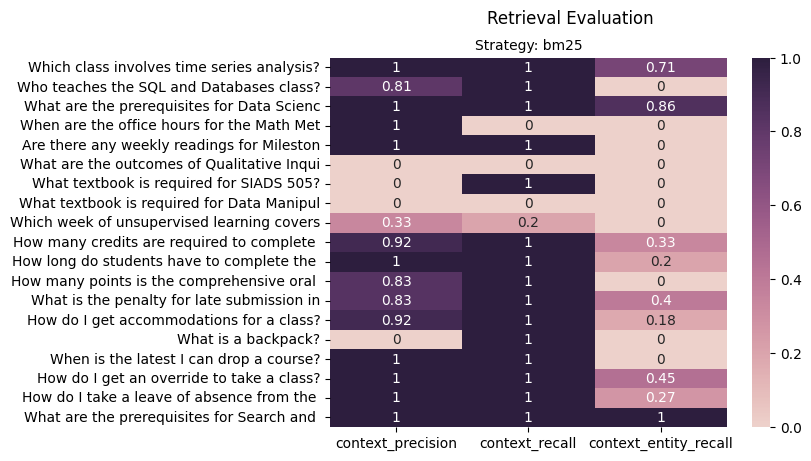

In [15]:
sns.heatmap(
    results_df[["context_precision", "context_recall", "context_entity_recall"]],
    yticklabels=results_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),  # cmap="YlGnBu",
)

plt.suptitle("Retrieval Evaluation")
plt.title(f"Strategy: {retrieval_strategy}", fontsize=10)

plt.show()

## Ensemble Retriever

In [ ]:
import numpy as np

def partition_equally_by_n(n):
  return list(np.ones(n) / n)

partition_equally_by_n(3)

In [ ]:
from langchain.retrievers import TFIDFRetriever, BM25Retriever, EnsembleRetriever

chroma_retriever = document_db.as_retriever(
    search_type="mmr",  # Maximum marginal relevance
    search_kwargs={"k": 5, "fetch_k": 20},
)

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfidf_retriever = TFIDFRetriever.from_documents(
    docs, tfidf_params={"stop_words": "english", "min_df": 1}
)

bm25_retriever = BM25Retriever.from_documents(docs)

retrievers = [
    chroma_retriever,
    tfidf_retriever,
    # bm25_retriever
]
weights = partition_equally_by_n(len(retrievers))

ensemble_retriever = EnsembleRetriever(retrievers=retrievers, weights=weights)

In [ ]:
ensemble_result = ensemble_retriever.invoke(
    "Which class involves time series analysis?"
)

print_docs(ensemble_result)